In [17]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [18]:
# Set random seed for reproducibility
np.random.seed(42)

## Load the MNIST dataset


In [19]:
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

Loading MNIST dataset...


## Check overall type

In [20]:
import numpy as np

print(type(y))            # Check overall type (usually numpy.ndarray)
print(y.dtype)            # Data type inside the array
print(np.unique(y)[:10])  # First 10 unique labels


<class 'numpy.ndarray'>
object
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Preprocessing MNIST dataset


### the first step is to normalize features (X)

- Original MNIST pixels are integers in the range [0, 255]
- Divide by 255.0 to scale them into the range [0.0, 1.0]
- Convert to float32 for efficiency (less memory, faster training)

In [21]:
X = X.astype("float32") / 255.0

### the second step is to Clean labels (y)

- Ensure labels are stored as integers (0–9)
- int64 is safe for machine learning libraries

In [22]:
y = y.astype("int64")

- the thired step is a sanity check 
- i will check the dataset shape

In [23]:
print("Features shape:", X.shape)   # should be (70000, 784)
print("Labels shape:", y.shape)     # should be (70000,)

Features shape: (70000, 784)
Labels shape: (70000,)


- Check pixel value range
- Before normalization → 0 to 255
- After normalization  → 0.0 to 1.0

In [24]:
print("X range:", "the smallest pixel value " , X.min(), "the largest pixel value" , X.max())

X range: the smallest pixel value  0.0 the largest pixel value 1.0


### - Check label classes
- For MNIST → digits from 0 to 9

In [27]:
print("y classes:", np.unique(y))

y classes: [0 1 2 3 4 5 6 7 8 9]


### - Split into training and testing sets


- test_size=0.3 → 30% of data for testing (14,000 samples)
- random_state=42 → ensures reproducibility

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### - define candidate models

- Create a dictionary of classifiers
- Keys are model names
- Values are initialized classifier objects

In [29]:
classifiers = {
    "LogReg": LogisticRegression(max_iter=1200, random_state=1),  # Higher iterations
    "SVM (RBF)": SVC(kernel="rbf", C=1.0, random_state=1),       # Added C param
    "DecisionTree": DecisionTreeClassifier(max_depth=None, random_state=1),
    "RandomForest": RandomForestClassifier(n_estimators=120, random_state=1),  # Slightly different
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=1),
}

### -Train, evaluate & collect results


In [30]:
results_summary = {}
wrong_predictions = {}

for clf_name, clf in classifiers.items():
    print(f"Fitting {clf_name} ...")
    start = time.time()
    
    # Train
    clf.fit(X_train, y_train)
    duration = round(time.time() - start, 2)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    rep = classification_report(y_test, y_pred, output_dict=True)
    cmatrix = confusion_matrix(y_test, y_pred)
    
    # Store results
    results_summary[clf_name] = {
        "accuracy": acc,
        "report": rep,
        "confusion": cmatrix,
        "train_time": duration
    }
    
    # Save misclassified examples (only first 5)
    mis_idx = np.where(y_pred != y_test)[0][:5]
    wrong_predictions[clf_name] = {
        "img": X_test[mis_idx],
        "true": y_test[mis_idx],
        "pred": y_pred[mis_idx]
    }
    
    # Display report
    print(classification_report(y_test, y_pred))


Fitting LogReg ...
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2058
           1       0.95      0.97      0.96      2364
           2       0.91      0.90      0.91      2133
           3       0.90      0.89      0.90      2176
           4       0.92      0.93      0.92      1936
           5       0.89      0.88      0.88      1915
           6       0.94      0.95      0.95      2088
           7       0.93      0.94      0.94      2248
           8       0.90      0.87      0.88      1992
           9       0.89      0.90      0.90      2090

    accuracy                           0.92     21000
   macro avg       0.92      0.92      0.92     21000
weighted avg       0.92      0.92      0.92     21000

Fitting SVM (RBF) ...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2058
           1       0.98      0.99      0.99      2364
           2       0.97      0.98    

C:\Users\bbuser\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:41:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2058
           1       0.98      0.99      0.99      2364
           2       0.97      0.98      0.97      2133
           3       0.98      0.96      0.97      2176
           4       0.97      0.98      0.98      1936
           5       0.98      0.97      0.98      1915
           6       0.98      0.99      0.98      2088
           7       0.97      0.98      0.97      2248
           8       0.97      0.97      0.97      1992
           9       0.96      0.97      0.96      2090

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



### - Results summary dataframe


In [31]:
perf_df = pd.DataFrame({
    model: {
        "Accuracy": round(results_summary[model]["accuracy"], 4),
        "Train Time (s)": results_summary[model]["train_time"]
    }
    for model in results_summary
}).T

print("\n--- Model Comparison ---")
print(perf_df)


--- Model Comparison ---
              Accuracy  Train Time (s)
LogReg          0.9205           39.13
SVM (RBF)       0.9763          276.34
DecisionTree    0.8660           21.19
RandomForest    0.9667           54.48
XGBoost         0.9762          188.29


### - Accuracy comparison bar chart

C:\Users\bbuser\AppData\Local\Temp\ipykernel_7288\2796381406.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_df.reset_index(), x="index", y="Accuracy", palette="viridis")


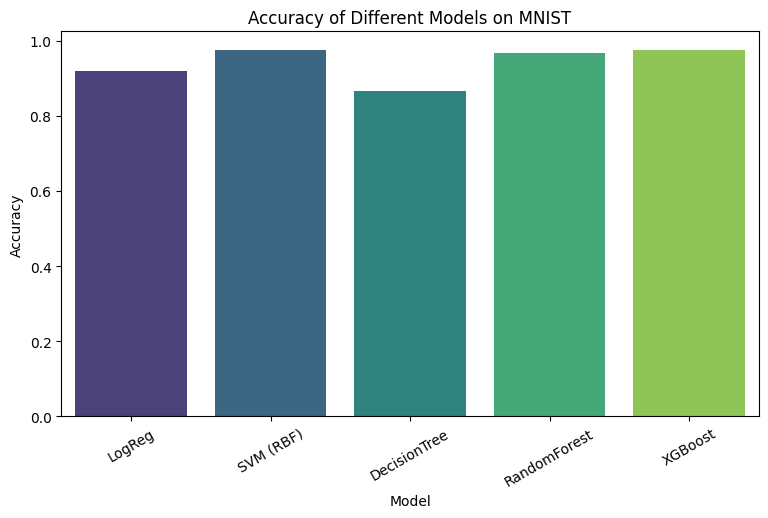

In [32]:
plt.figure(figsize=(9, 5))
sns.barplot(data=perf_df.reset_index(), x="index", y="Accuracy", palette="viridis")
plt.title("Accuracy of Different Models on MNIST")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

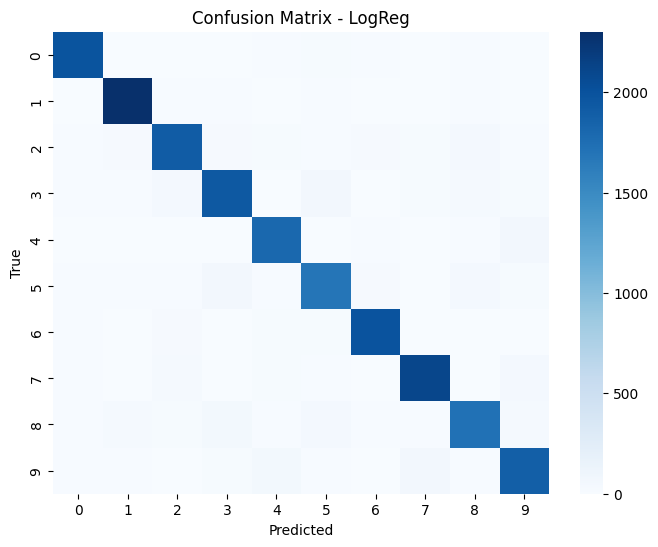

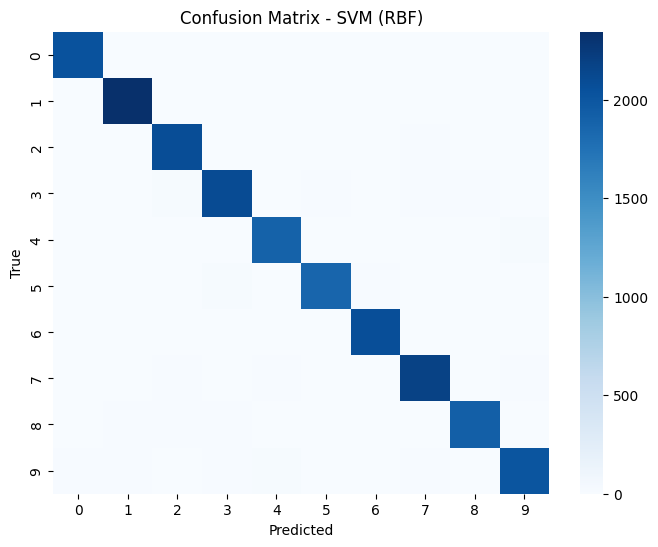

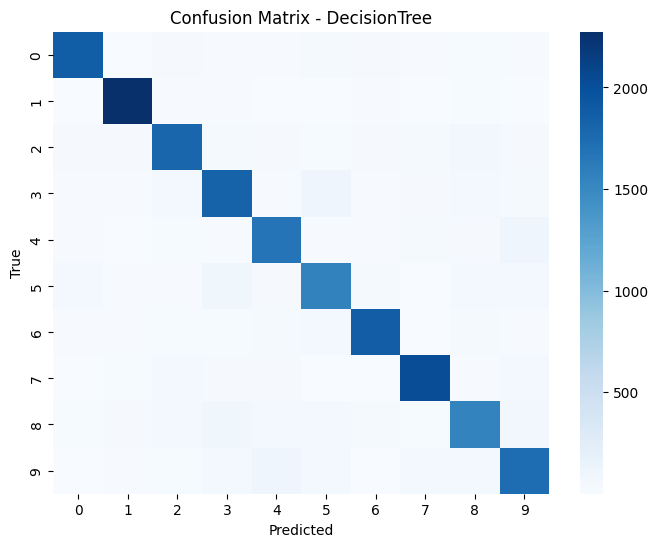

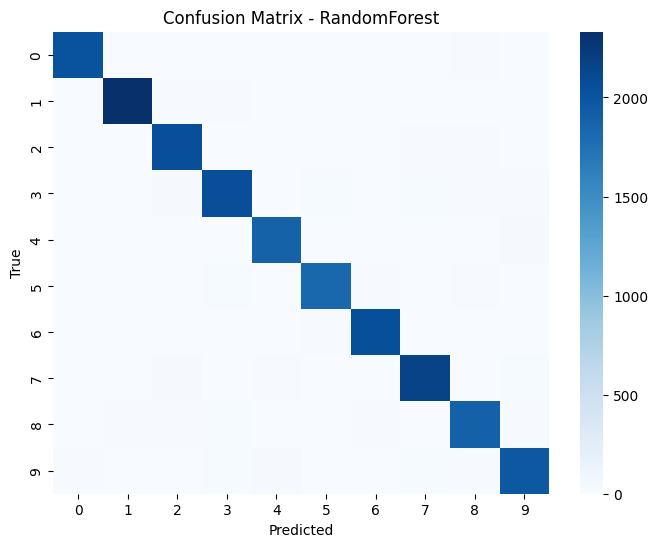

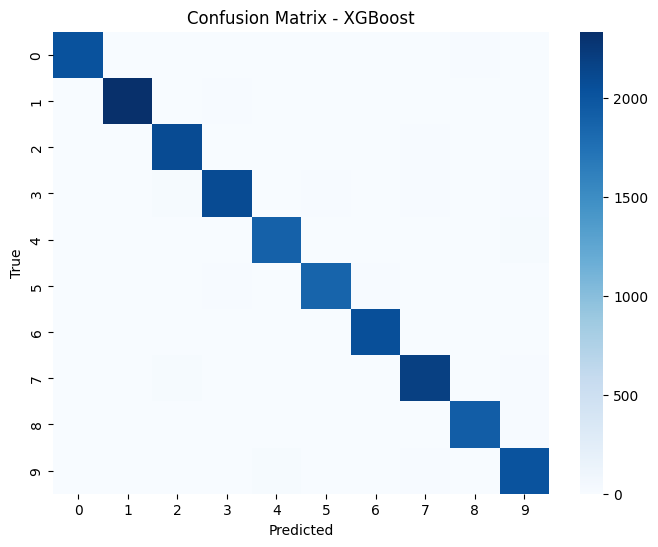

In [33]:
for model_name, data in results_summary.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(data["confusion"], cmap="Blues", annot=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

### - Confusion matrices

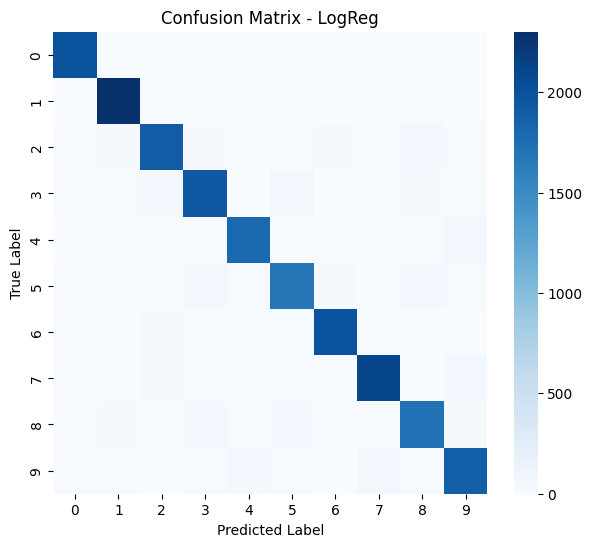

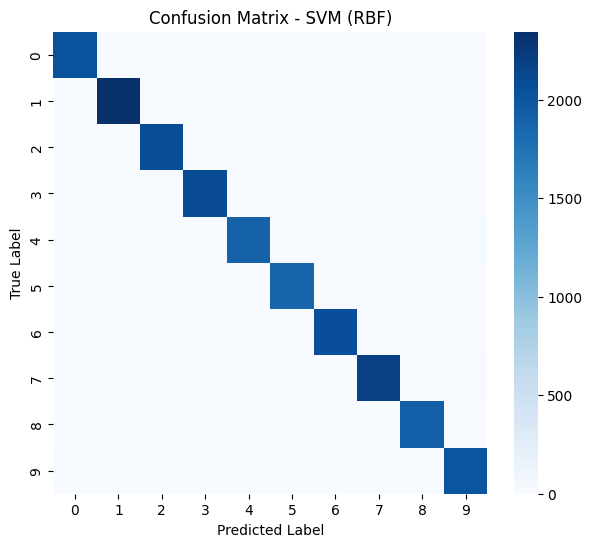

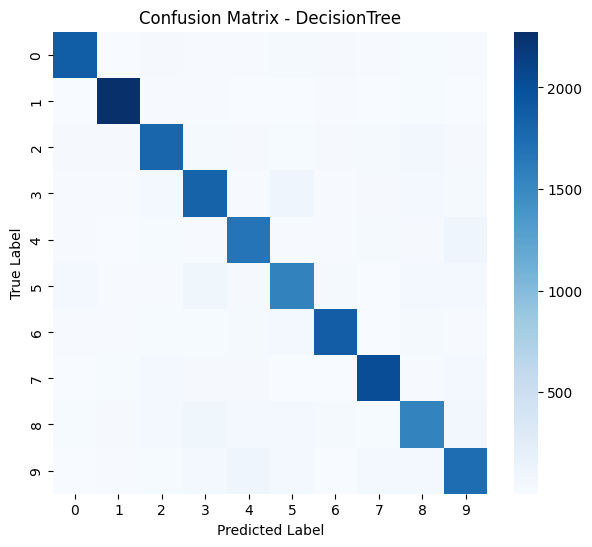

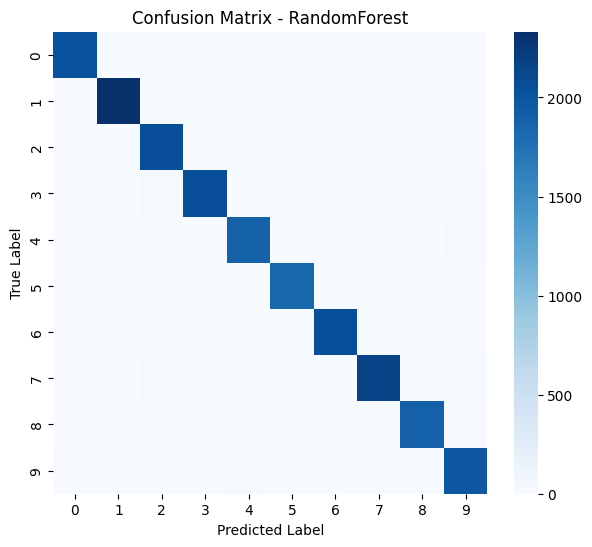

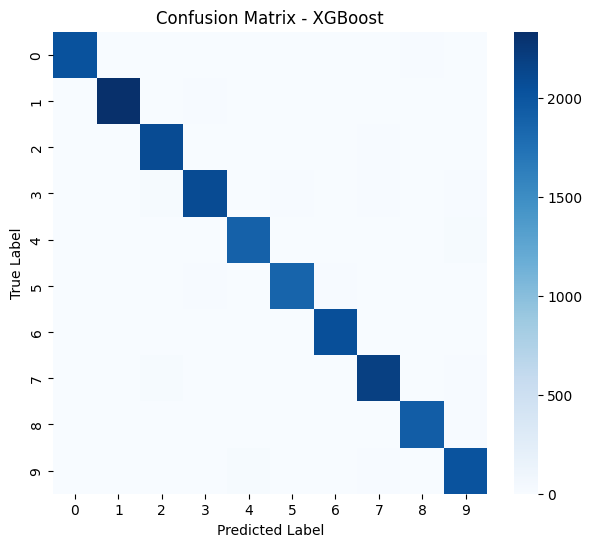

In [34]:
for model, info in results_summary.items():
    plt.figure(figsize=(7, 6))
    sns.heatmap(info["confusion"], cmap="Blues", annot=False, cbar=True)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### - Display sample misclassified images

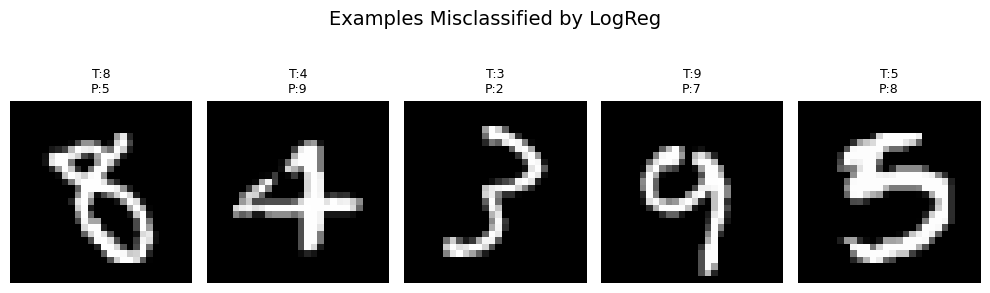

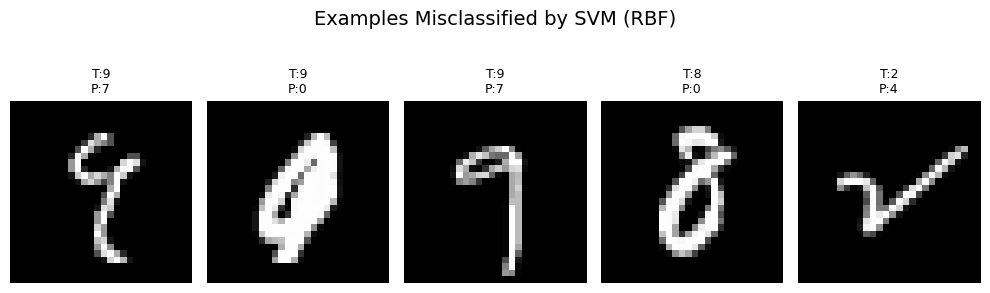

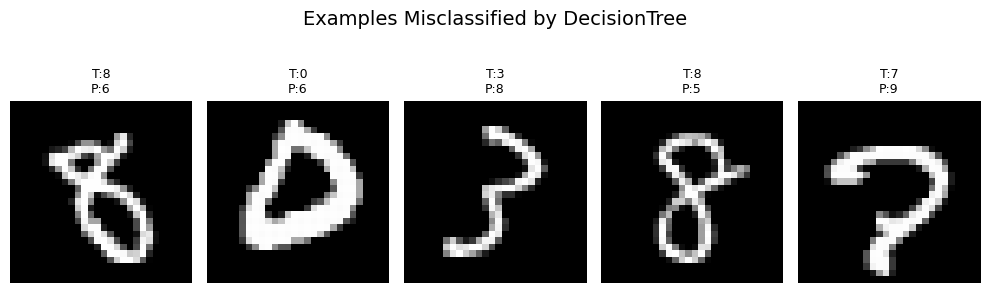

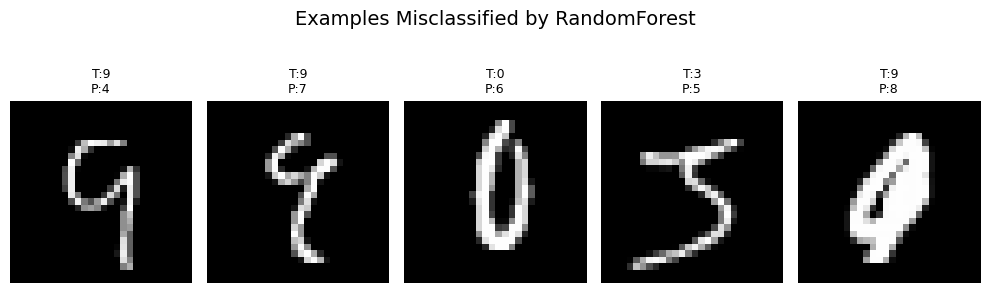

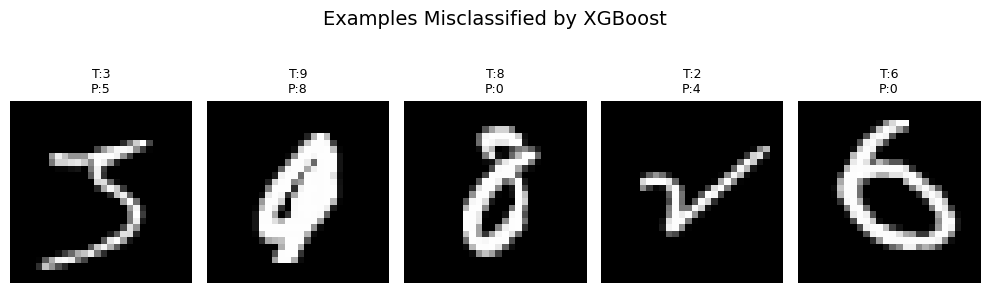

In [35]:
for model, mis in wrong_predictions.items():
    reshaped_imgs = mis["img"].reshape(-1, 28, 28)
    t_labels, p_labels = mis["true"], mis["pred"]
    
    plt.figure(figsize=(10, 3))
    plt.suptitle(f"Examples Misclassified by {model}", fontsize=14, y=1.05)
    
    for i in range(len(reshaped_imgs)):
        plt.subplot(1, 5, i+1)
        plt.imshow(reshaped_imgs[i], cmap="gray")
        plt.title(f"T:{t_labels[i]}\nP:{p_labels[i]}", fontsize=9)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()